## importing dataset

In [ ]:
import pandas as pd
df=pd.read_excel('/content/Imdb.xlsx')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Check Missing Values

In [ ]:
# Check for missing values
df.isnull().sum()


,0
review,0
sentiment,0


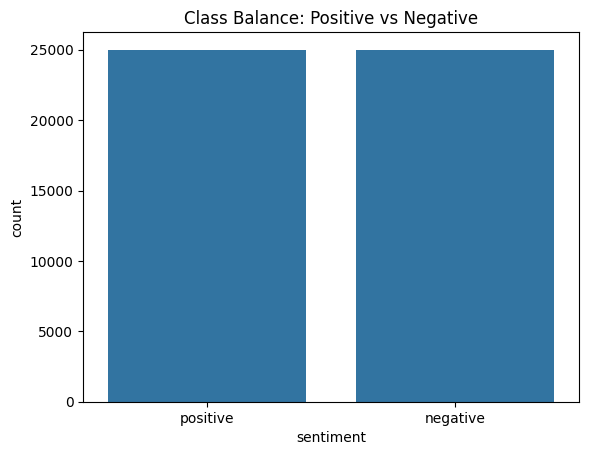

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Class distribution
sns.countplot(data=df, x='sentiment')
plt.title("Class Balance: Positive vs Negative")
plt.show()

# Encode sentiment: positive -> 1, negative -> 0
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})


## Review Length Distribution

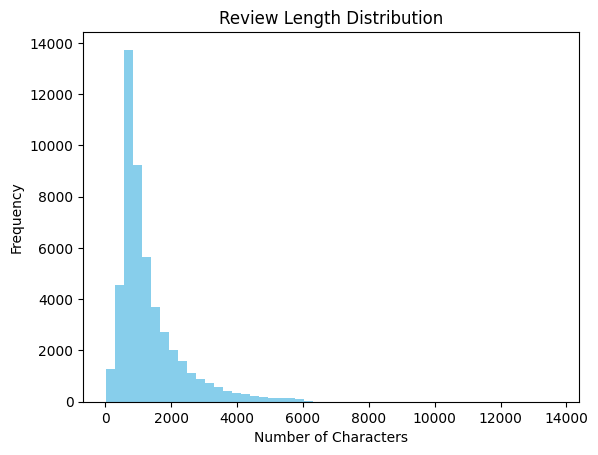

In [ ]:
# Add review length column
df['review_length'] = df['review'].apply(len)

# Plot histogram
plt.hist(df['review_length'], bins=50, color='skyblue')
plt.title("Review Length Distribution")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.show()


##  Text Cleaning & Preprocessing

In [ ]:
import re
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Initialize tools
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def clean_and_preprocess(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Lowercase and remove punctuation/special chars
    text = re.sub(r'[^\w\s]', '', text.lower())

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Stemming
    tokens = [stemmer.stem(word) for word in tokens]

    return ' '.join(tokens)

# Apply cleaning to dataset
df['clean_review'] = df['review'].apply(clean_and_preprocess)
df[['review', 'clean_review']].head()


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


,review,clean_review
0,One of the other reviewers has mentioned that ...,one review mention watch 1 oz episod youll hoo...
1,A wonderful little production. <br /><br />The...,wonder littl product film techniqu unassum old...
2,I thought this was a wonderful way to spend ti...,thought wonder way spend time hot summer weeke...
3,Basically there's a family where a little boy ...,basic there famili littl boy jake think there ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",petter mattei love time money visual stun film...


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize BoW
bow_vectorizer = CountVectorizer(max_features=5000)
X_bow = bow_vectorizer.fit_transform(df['clean_review'])

X_bow.shape  # Check shape


(50000, 5000)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(df['clean_review'])

X_tfidf.shape  # Check shape


(50000, 5000)

# Feature Engineering

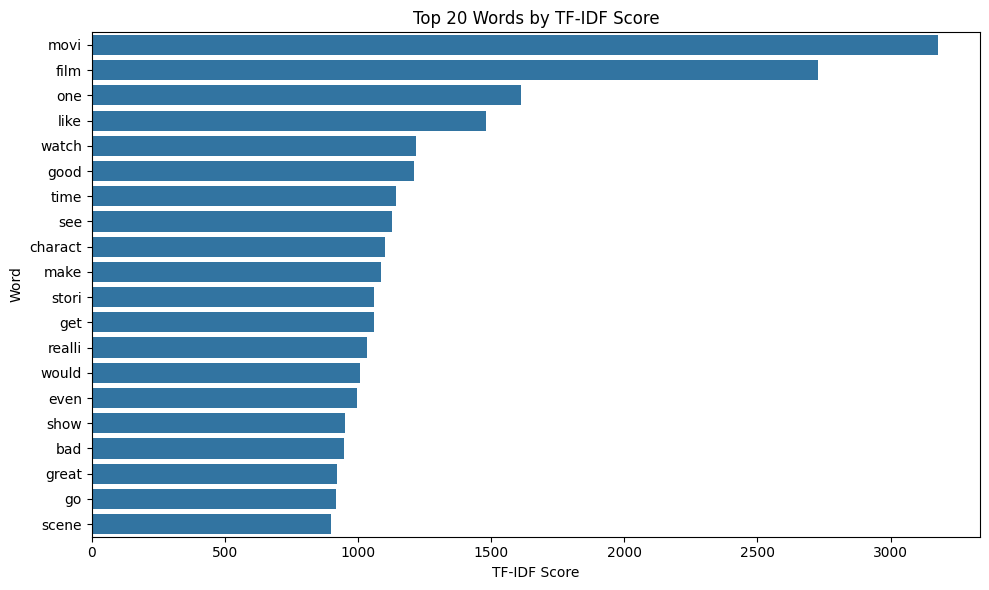

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Sum TF-IDF scores across all documents
tfidf_scores = np.sum(X_tfidf.toarray(), axis=0)
words = tfidf_vectorizer.get_feature_names_out()

# Create DataFrame
tfidf_df = pd.DataFrame({'word': words, 'score': tfidf_scores})
top_words = tfidf_df.sort_values(by='score', ascending=False).head(20)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='score', y='word', data=top_words)
plt.title("Top 20 Words by TF-IDF Score")
plt.xlabel("TF-IDF Score")
plt.ylabel("Word")
plt.tight_layout()
plt.show()


In [ ]:
# Word count
df['word_count'] = df['clean_review'].apply(lambda x: len(x.split()))

# Character count
df['char_count'] = df['clean_review'].apply(len)

# Average word length
df['avg_word_len'] = df['char_count'] / df['word_count']
# Display review and its textual features
df[['clean_review', 'word_count', 'char_count', 'avg_word_len']].head()



,clean_review,word_count,char_count,avg_word_len
0,one review mention watch 1 oz episod youll hoo...,168,1047,6.232143
1,wonder littl product film techniqu unassum old...,84,565,6.726190
2,thought wonder way spend time hot summer weeke...,86,532,6.186047
3,basic there famili littl boy jake think there ...,67,413,6.164179
4,petter mattei love time money visual stun film...,125,766,6.128000


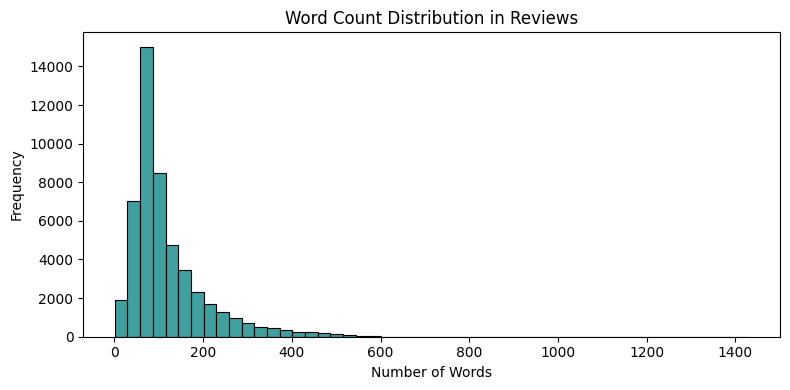

In [ ]:
plt.figure(figsize=(8, 4))
sns.histplot(df['word_count'], bins=50, color='teal')
plt.title("Word Count Distribution in Reviews")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


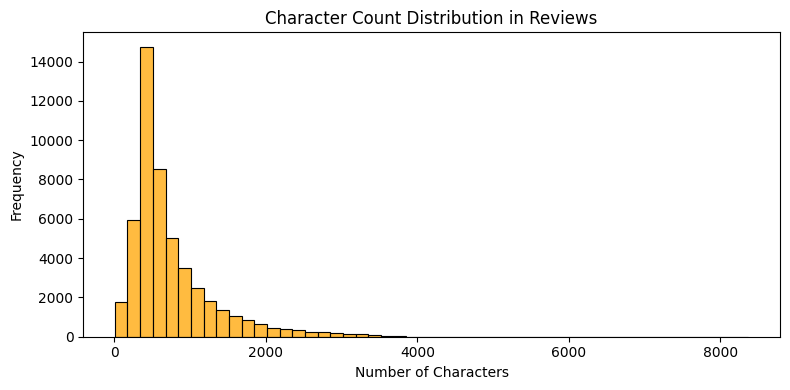

In [ ]:
plt.figure(figsize=(8, 4))
sns.histplot(df['char_count'], bins=50, color='orange')
plt.title("Character Count Distribution in Reviews")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


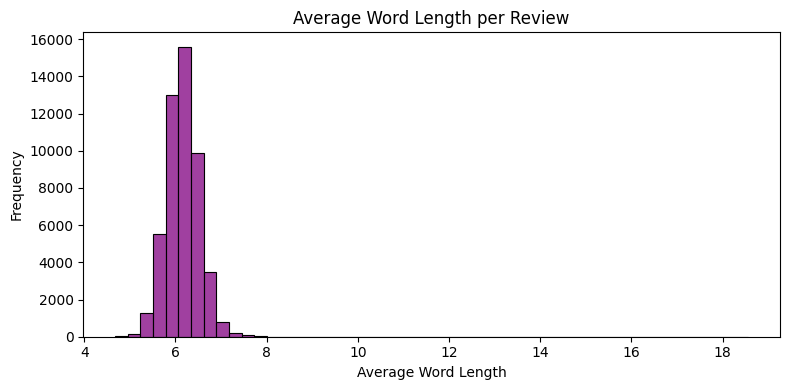

In [ ]:
plt.figure(figsize=(8, 4))
sns.histplot(df['avg_word_len'], bins=50, color='purple')
plt.title("Average Word Length per Review")
plt.xlabel("Average Word Length")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


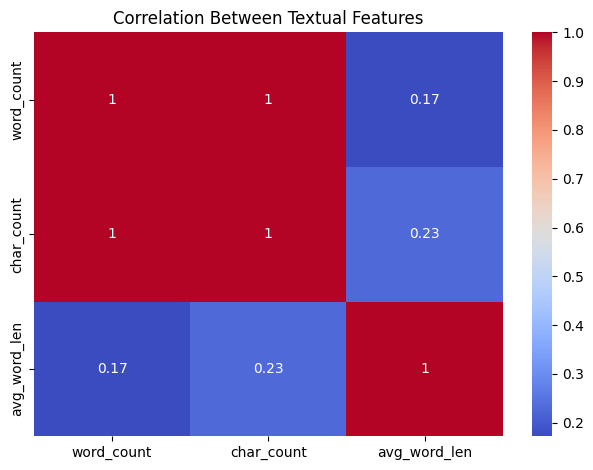

In [ ]:
sns.heatmap(df[['word_count', 'char_count', 'avg_word_len']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Between Textual Features")
plt.tight_layout()
plt.show()


## Model development

train test split

In [ ]:
from sklearn.model_selection import train_test_split

# Use TF-IDF + textual features
X = X_tfidf
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(max_iter=500)
lr_model.fit(X_train, y_train)

print("Logistic Regression")
print("Train Accuracy:", lr_model.score(X_train, y_train))
print("Test Accuracy:", lr_model.score(X_test, y_test))


Logistic Regression
Train Accuracy: 0.90775
Test Accuracy: 0.8851


naive bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

print("Naive Bayes")
print("Train Accuracy:", nb_model.score(X_train, y_train))
print("Test Accuracy:", nb_model.score(X_test, y_test))


Naive Bayes
Train Accuracy: 0.857875
Test Accuracy: 0.8498


support vector machine

In [ ]:
from sklearn.svm import SVC

svm_model = SVC()
svm_model.fit(X_train, y_train)

print("SVM")
print("Train Accuracy:", svm_model.score(X_train, y_train))
print("Test Accuracy:", svm_model.score(X_test, y_test))


SVM
Train Accuracy: 0.980475
Test Accuracy: 0.8897


random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=30, random_state=42)
rf_model.fit(X_train, y_train)

print("Random Forest")
print("Train Accuracy:", rf_model.score(X_train, y_train))
print("Test Accuracy:", rf_model.score(X_test, y_test))


Random Forest
Train Accuracy: 0.999875
Test Accuracy: 0.8287


## LSTM

In [ ]:
!pip install -U tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.model_selection import train_test_split
# Initialize tokenizer
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df['clean_review'])

# Convert text to padded sequences
X_seq = tokenizer.texts_to_sequences(df['clean_review'])
X_pad = pad_sequences(X_seq, maxlen=200)

# Target variable
y = df['sentiment']

X_train_pad, X_test_pad, y_train_pad, y_test_pad = train_test_split(
    X_pad, y, test_size=0.2, stratify=y, random_state=42
)
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=64, input_length=200))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(
    X_train_pad, y_train_pad,
    epochs=3,
    batch_size=64,
    validation_data=(X_test_pad, y_test_pad)
)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 35.1 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.18.0
    Uninstalling tensorflow-2.18.0:
      Successfully uninstalled tensorflow-2.18.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


625/625 ━━━━━━━━━━━━━━━━━━━━ 165s 257ms/step - accuracy: 0.7697 - loss: 0.4782 - val_accuracy: 0.8711 - val_loss: 0.3109
Epoch 2/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 160s 255ms/step - accuracy: 0.8969 - loss: 0.2678 - val_accuracy: 0.8741 - val_loss: 0.3027
Epoch 3/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 163s 261ms/step - accuracy: 0.9103 - loss: 0.2330 - val_accuracy: 0.8774 - val_loss: 0.2971


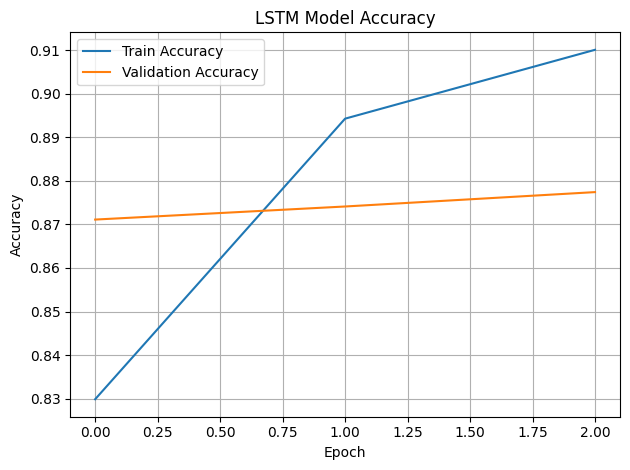

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


##  Model Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


Choosed a model logistic regression

In [ ]:
best_model = lr_model
y_pred = best_model.predict(X_test)


In [ ]:
# Basic Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))


Accuracy: 0.8851
Precision: 0.8767364507924086
Recall: 0.8962
F1 Score: 0.8863613885866878


Confusion Matrix

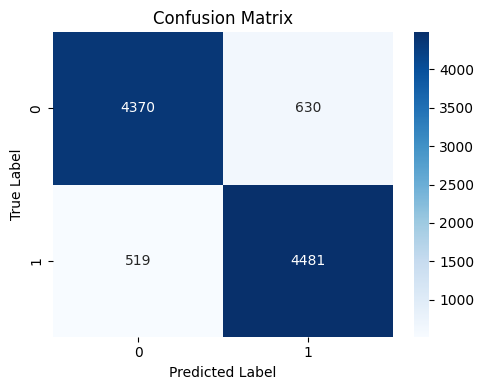

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


prediction of new reviews

In [ ]:
new_reviews = ["The movie was fantastic!", "It was boring and too long."]

# Preprocess (must match training)
new_reviews_cleaned = [clean_and_preprocess(review) for review in new_reviews]

# Transform to TF-IDF
X_new = tfidf_vectorizer.transform(new_reviews_cleaned)

# Predict
predictions = lr_model.predict(X_new)

# Show results
for review, pred in zip(new_reviews, predictions):
    print(f"Review: {review}\nPredicted Sentiment: {'Positive' if pred == 1 else 'Negative'}\n")


Review: The movie was fantastic!
Predicted Sentiment: Positive

Review: It was boring and too long.
Predicted Sentiment: Negative



LSTM model

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Preprocess
new_reviews = ["The movie was terrible.", "Absolutely loved it!"]
new_reviews_cleaned = [clean_and_preprocess(review) for review in new_reviews]

# Tokenize and pad
seqs = tokenizer.texts_to_sequences(new_reviews_cleaned)
X_new_pad = pad_sequences(seqs, maxlen=200)

# Predict
pred_probs = model.predict(X_new_pad)
pred_labels = (pred_probs > 0.5).astype(int)

# Show results
for review, pred in zip(new_reviews, pred_labels):
    print(f"Review: {review}\nPredicted Sentiment: {'Positive' if pred == 1 else 'Negative'}\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 832ms/step
Review: The movie was terrible.
Predicted Sentiment: Negative

Review: Absolutely loved it!
Predicted Sentiment: Positive



BERT model

In [ ]:
!pip install transformers


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# Load tokenizer and model
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def predict_bert_sentiment(text):
    # Tokenize using Hugging Face tokenizer
    inputs = bert_tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)

    # Get output from model
    outputs = bert_model(**inputs)

    # Apply softmax to get probabilities
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)

    # Interpret the prediction
    return "Positive" if torch.argmax(probs).item() == 1 else "Negative"


In [ ]:
print(predict_bert_sentiment("The acting was brilliant and emotional."))


Negative


Classification Report

In [ ]:
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))


Classification Report:
              precision    recall  f1-score   support

    Negative       0.89      0.87      0.88      5000
    Positive       0.88      0.90      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



ROC-AUC

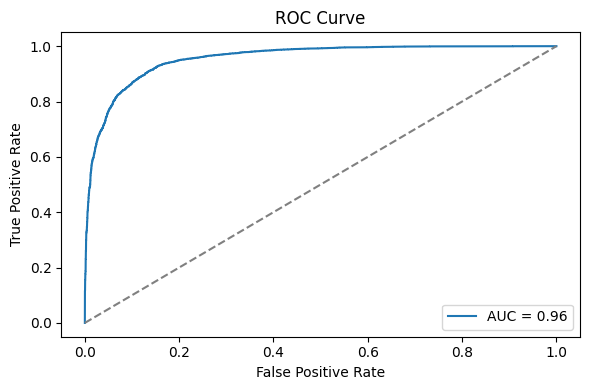

In [ ]:
from sklearn.metrics import roc_curve, auc

y_prob = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.show()
